# Oral Dosing Pharmacokinetic (PK) model.
## This project implements three component PK model with first order rate constants and estimates its parameters.

- **Gut compartment (Ag)** — Dose administration site 
- **Central compartment (Ac)** — plasma / systemic circulation  
- **Peripheral compartment (Ap)** — tissue distribution compartment

Following are the first order rate constants according to which the drug flows through the body.
- **Absorption:** \( k_a \)  
- **Elimination:** \( k_{10} \)  
- **Distribution:** \( k_{12} \) (central → peripheral)  
- **Redistribution:** \( k_{21} \) (peripheral → central)

## Model equations
Let  
- \(A_g(t)\) = amount of drug in gut  
- \(A_c(t)\) = amount of drug in central compartment  
- \(A_p(t)\) = amount of drug in peripheral compartment
  
- **Gut compartment**
$$\frac{dA_g}{dt} = - k_a A_g$$

- **Central Compartment**
  $$\frac{dA_c}{dt} = k_a A_g - (k_{10} + k_{12})A_c + k_{12} A_p$$

- **Peripheral Compartment**
  $$ \frac{dA_p}{dt} = k_{12}A_c - k_{21} A_p$$

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

def Oral_dosing_ode(t, y, ka, k10, k12, k21):
    Ag, Ac, Ap = y
    dAgdt = -ka * Ag
    dAcdt = ka*Ag - (k10 + k12)*Ac + k21*Ap
    dApdt = k12*Ac - k21*Ap
    return dAgdt, dAcdt, dApdt

## Solving ODEs
We solved the above set of differential equations using `solve_ivp` to obtain 
- A_g, A_c, A_p: Amount of drugs in different compartments.
- Cg, Cc, Cp: Concentration of drugs in different compartments.

In [4]:
def solution_ivp(times, y0, params):
    Vg, Vc, Vp, ka, k10, k12, k21 = params
    sol = solve_ivp(lambda tt, y: Oral_dosing_ode(tt, y, ka, k10, k12, k21), (times[0], times[-1]), y0, t_eval = times)
    Ag, Ac, Ap = sol.y
    Cg = Ag/Vg
    Cc = Ac/Vc
    Cp = Ap/Vp
    return Cg, Ag, Cc, Ac, Cp, Ap

dose = 500
params_true = [50, 50, 50, 0.12, 0.12, 0.12, 0.12]
times = np.linspace(0, 24, 201)
y0 = [dose, 0, 0]
Cg_true, Ag_true, Cc_true, Ac_true, Cp_true, Ap_true = solution_ivp(times, y0, params_true)

## Generating Synthetic Observed data
We simulate noisy observed concentrations by adding Gaussian noise (σ = 0.3 mg/L) to the model predictions.

In [7]:
Cg_obs = Cg_true + np.random.normal(0, 0.2, len(Cg_true))
Cc_obs = Cc_true + np.random.normal(0, 0.2, len(Cc_true))
Cp_obs = Cp_true + np.random.normal(0, 0.2, len(Cp_true))

## Residual Function for Parameter Fitting
The difference between the observed and the model predicted concentrations is termed as redidue. We use this model to obtain the fitting parameters, `ka, k10, k12, k21` that minimizes the residue. We use scipy.optimize.least_squares to find the parameters that minimize the residuals.

In [8]:

def residuals_pk(p):
    if np.any(np.array(p) <= 0):
        return 1e6 * np.ones(2 * len(times)) 
    Cg_model, Ag_model, Cc_model, Ac_model, Cp_model, Ap_model = solution_ivp(times, y0, p)
    res = np.concatenate([(Cg_model - Cg_obs), (Cc_model - Cc_obs), (Cp_model - Cp_obs)])
    return res
p0 = [60, 60, 40, 0.1, 0.08, 0.1, 0.05]
lower = [1e-3, 1e-3, 1e-3, 1e-6, 1e-6, 1e-6, 1e-6]
upper = [1000.0, 1000.0, 1000.0, 10.0, 10.0, 10.0, 10.0]

res = least_squares(residuals_pk, p0, bounds=(lower, upper))
print("Estimated parameters:", res.x)

Estimated parameters: [49.50620322 49.78422264 53.63701868  0.12205164  0.1193092   0.12573287
  0.11919359]


## Observed data and model fit comparison.
We visualize how well the fitted model reproduces the observed (noisy) concentration–time profiles for both compartments.

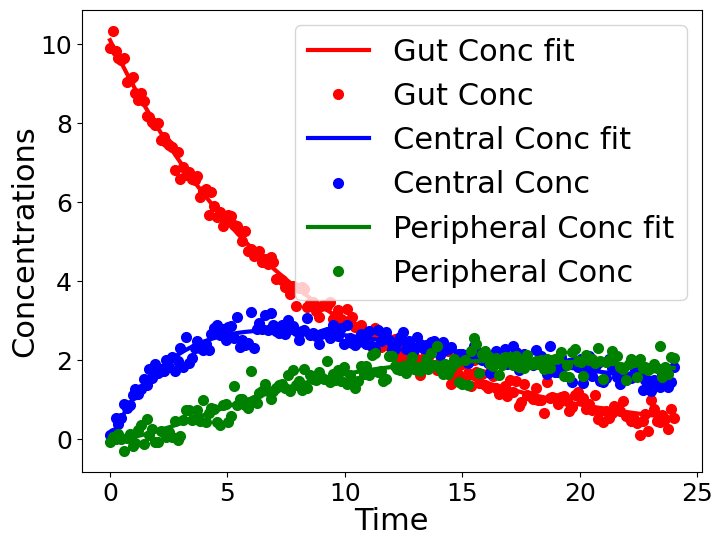

In [13]:
Cg_fit, Ag_fit, Cc_fit, Ac_fit, Cp_fit, Ap_fit = solution_ivp(times, y0, res.x)

plt.plot(times, Cg_fit, 'r', label="Gut Conc fit")
plt.plot(times, Cg_obs, 'r.', label="Gut Conc")

plt.plot(times, Cc_fit, 'b',label = "Central Conc fit")
plt.plot(times, Cc_obs, 'b.', label = "Central Conc")

plt.plot(times, Cp_fit, 'g', label = "Peripheral Conc fit")
plt.plot(times, Cp_obs, 'g.', label = "Peripheral Conc")
plt.xlabel("Time")
plt.ylabel("Concentrations")
plt.legend()
plt.show()